## Importing libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ARIMA,auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from matplotlib.pyplot import vlines


import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [152]:
data = pd.read_csv('final.csv')

In [153]:
data

,Date,Customer_Name,Item_Name,Vrh_No,Quantity,Price_per_unit,Amount
0,2019-01-04,customer1,Item_1,1,200,20,4000
1,2019-01-04,customer7,Item_3,10,15,33,495
2,2019-01-04,customer7,Item_1,10,50,20,1000
3,2019-01-04,customer8,Item_11,11,80,30,2400
4,2019-01-04,customer8,Item_7,11,624,21,13416
...,...,...,...,...,...,...,...
1952,2021-12-01,customer132,Item_3,255,1,13,13
1953,2021-12-01,customer132,Item_3,255,958,20,19160
1954,2021-12-01,customer133,Item_3,260,900,23,20700
1955,2021-12-01,customer61,Item_27,257,30,57,1710


In [154]:
# Grouping the 'Amount' column by 'Date' in the 'data' DataFrame and aggregating the sum of the grouped values
df = data.groupby('Date')['Amount'].sum().reset_index()

In [155]:
# Renaming the "Amount" column to "Sales"
df.rename(columns = {'Amount':'Sales'}, inplace = True)

In [156]:
# Extracting the year from the "Date" column
df['year'] = pd.DatetimeIndex(df['Date']).year
df

,Date,Sales,year
0,2019-01-04,145339,2019
1,2019-01-05,23648,2019
2,2019-01-06,68106,2019
3,2019-01-10,40924,2019
4,2019-01-11,106511,2019
...,...,...,...
277,2021-07-01,92595,2021
278,2021-08-01,63082,2021
279,2021-09-01,69772,2021
280,2021-11-01,27467,2021


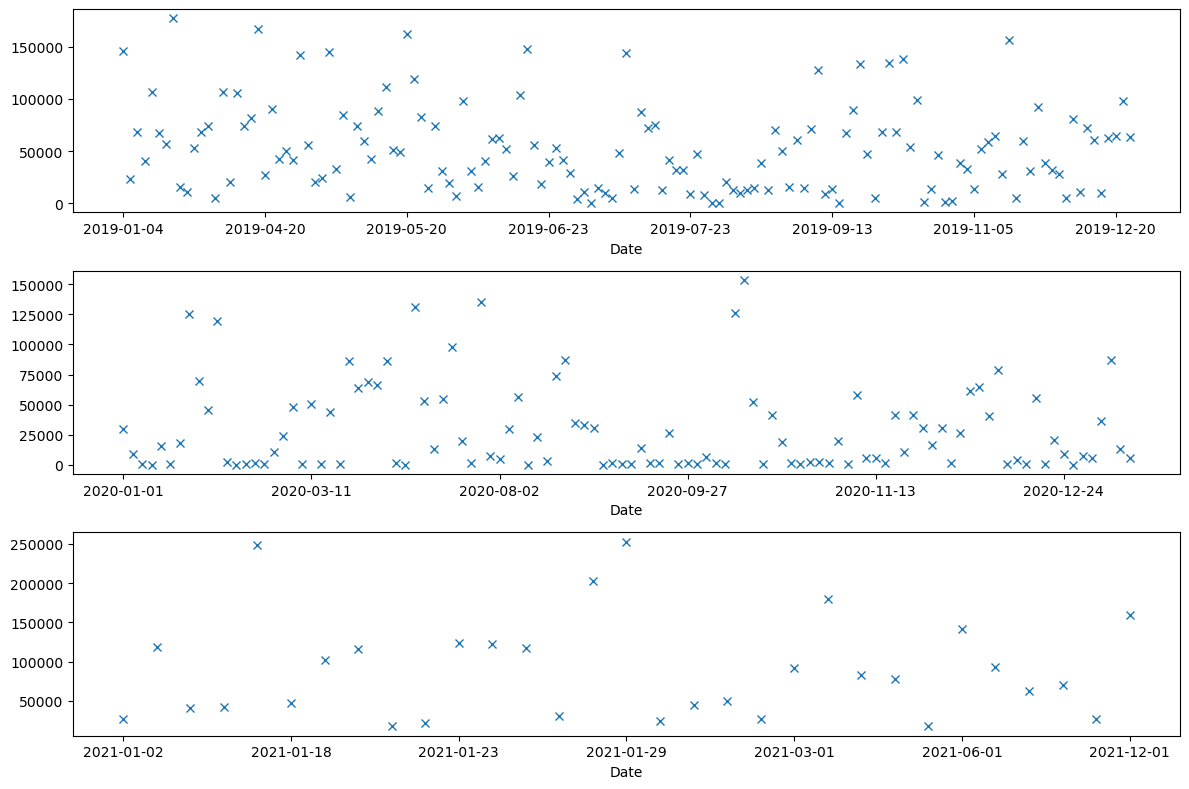

In [157]:
# Ploting time series data grouped by year
years= df.year.unique()
number_years= len(years)
fig, axes = plt.subplots(number_years, 1, figsize=(12, 8))
for i, year in enumerate(years):
    (df.set_index('Date')
       .loc[lambda df: df.year == year]
       .plot(y='Sales', ax=axes[i],marker='x',linestyle=""))    
    axes[i].legend_.remove()
fig.set_tight_layout("tight")

In [158]:
# Dropping the column beacuse it will not be required further
df.drop(['year'], axis=1,inplace=True)

In [159]:
df.dtypes

Date     object
Sales     int64
dtype: object

In [160]:
# Converting the datatype of "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [161]:
df.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [162]:
df['Date'].min()

Timestamp('2019-01-04 00:00:00')

In [163]:
df['Date'].max()

Timestamp('2021-12-01 00:00:00')

**Data is from 4th January 2019 to 1st December 2021**

In [164]:
# sorting the values of the df dataframe by date in ascending order
df.sort_values("Date", inplace = True)

In [165]:
# Setting the "Date" column as the index of the "df" DataFrame
df.set_index('Date', inplace=True) 

In [166]:
# Creating a new time series dataframe that has monthly aggregated mean of sales
df1 = df['Sales'].resample('M').mean()

In [167]:
# Interpolation is a technique used to estimate unknown data points between two known data points.
df1 = df1.interpolate(limit_direction="both")
df1

Date
2019-01-31     75352.500000
2019-02-28     63707.333333
2019-03-31     39731.000000
2019-04-30     74648.937500
2019-05-31     64861.882353
2019-06-30     44940.550000
2019-07-31     35403.000000
2019-08-31     28476.272727
2019-09-30     54266.428571
2019-10-31     56904.866667
2019-11-30     46498.600000
2019-12-31     58223.555556
2020-01-31     36402.083333
2020-02-29      2980.600000
2020-03-31     27922.500000
2020-04-30     43601.000000
2020-05-31     66401.666667
2020-06-30     47576.166667
2020-07-31     52841.833333
2020-08-31     34901.250000
2020-09-30     10711.642857
2020-10-31     26983.062500
2020-11-30     22239.090909
2020-12-31     27343.052632
2021-01-31     94565.333333
2021-02-28     38972.000000
2021-03-31     92490.000000
2021-04-30    131274.500000
2021-05-31     47439.500000
2021-06-30    141416.000000
2021-07-31     92595.000000
2021-08-31     63082.000000
2021-09-30     69772.000000
2021-10-31     48619.500000
2021-11-30     27467.000000
2021-12-31    1

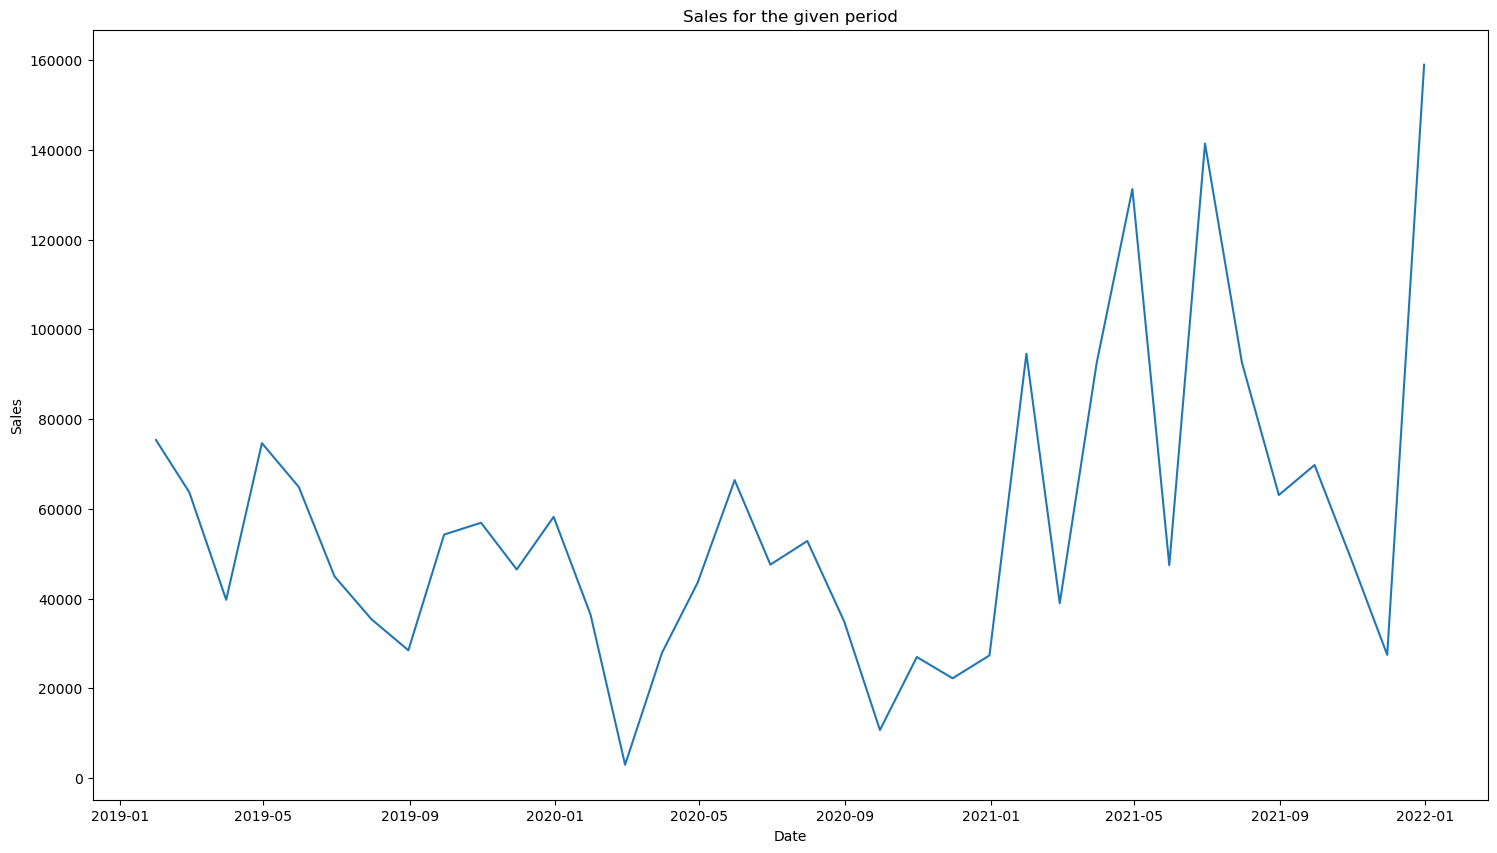

In [168]:
# Creating a line plot of the "Sales" data for the given period
plt.figure(figsize=(18,10))
plt.title('Sales for the given period')
sns.lineplot(data = df1)
plt.show()

**Sales is very low for starting of year 2020 and highest for ending of year 2021**

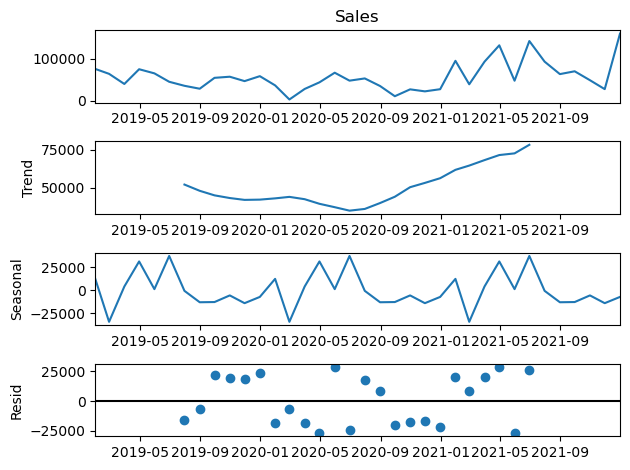

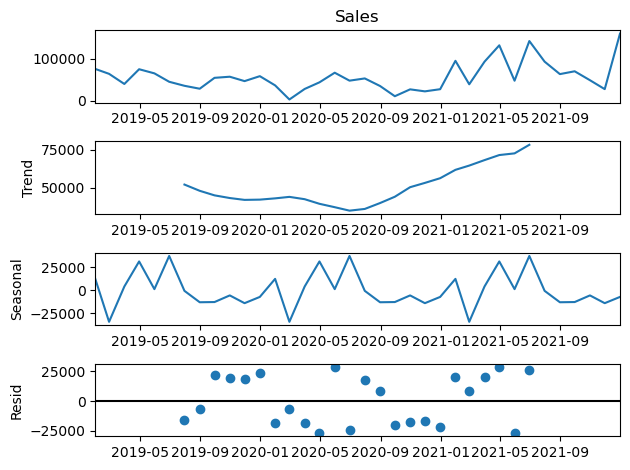

In [19]:
# Performing a time series decomposition
Decomposed_Series = seasonal_decompose(df1,model='additive')
Decomposed_Series.plot()

### Split in test and train in exactly 70 and 30% 

In [169]:
def split(df):
    size=int(len(df)*0.7)
    Train = df.iloc[:size]  # 70 %
    Test = df.iloc[size:] # 30 %
    return Train,Test

In [170]:
Train,Test = split(df1)

In [171]:
Train.shape

(25,)

In [172]:
Test.shape

(11,)

### Function for plotting and validating

In [173]:
def PlotValidation(model,df):
    Forecast = model.forecast(11).rename('Forecast') # Model Forecasting
    # Act, Forecast combining
    Actual_Forecast_Df = pd.concat([df, Forecast], axis = 1) 
    # Plot
    plt.figure(figsize=(18,10))
    sns.lineplot(data = Actual_Forecast_Df)
    plt.show()
    ## Validation
    Validation_Df = Actual_Forecast_Df[-11:].copy()
    print("MAPE",np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100) # MAPE
    print("RMSE",np.sqrt(np.mean((Validation_Df['Sales'] - Validation_Df['Forecast'])**2))) #RMSE

### Simple Exponential Smoothing (SES)

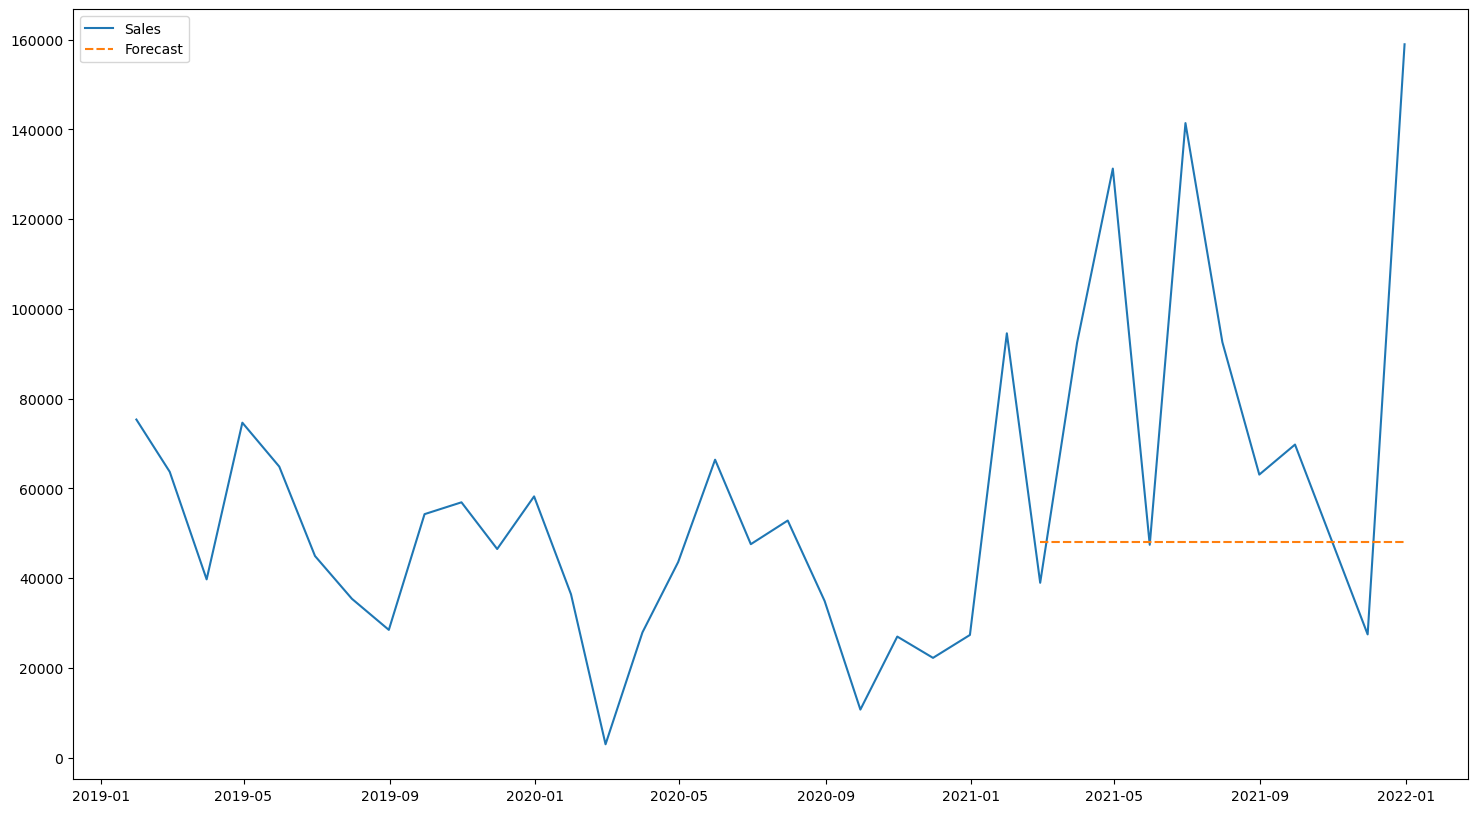

MAPE 44.97381626907841
RMSE 57603.18492155646


In [147]:
SES = SimpleExpSmoothing(Train).fit()
PlotValidation(SES,df1)

### Double Exponential Smoothing (DES)

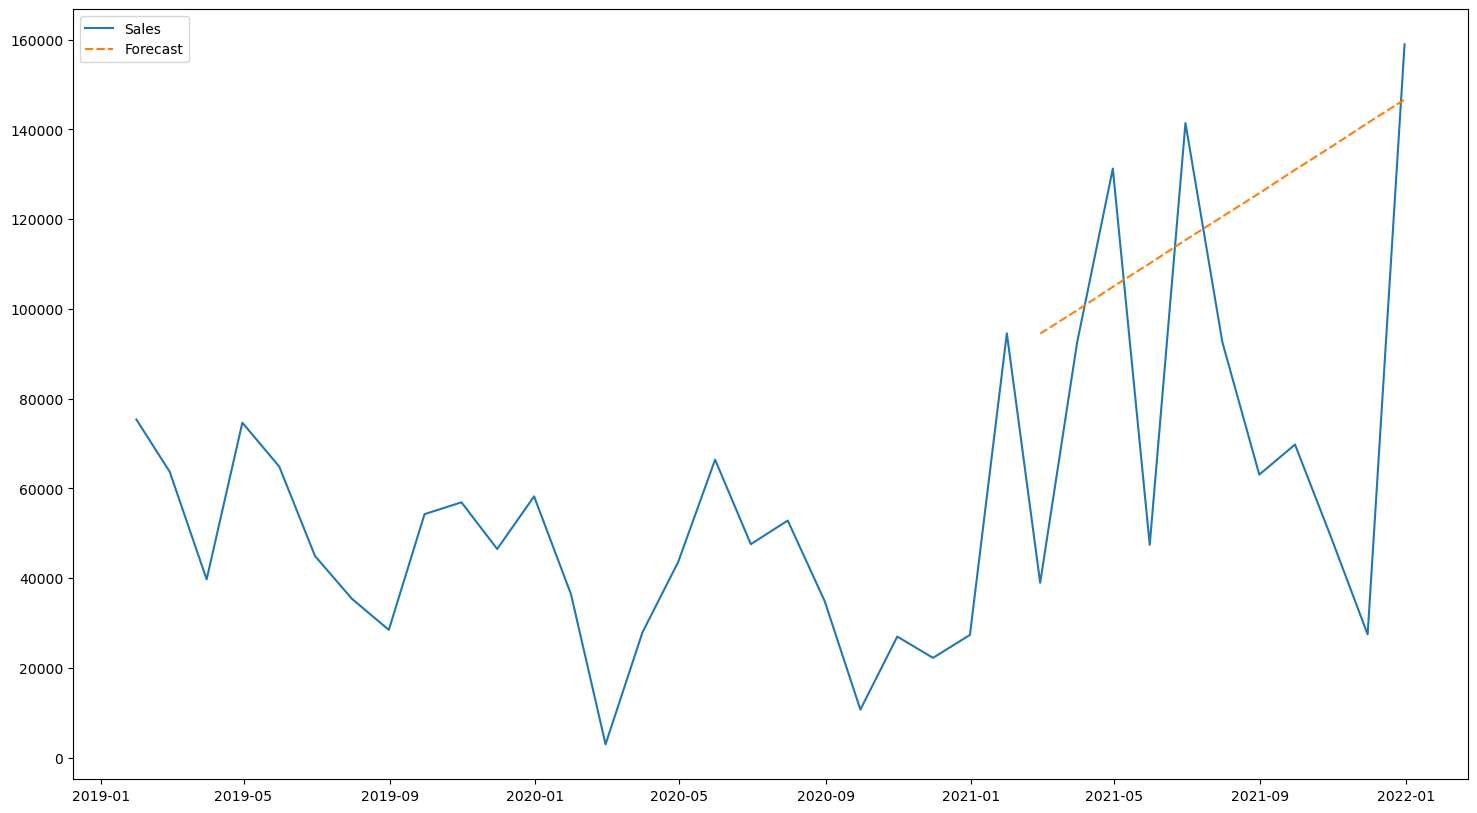

MAPE 103.74258703372668
RMSE 58556.991862496


In [30]:
DES = Holt(Train).fit()
PlotValidation(DES,df1)

In [27]:
# Finding best parameters for DES
myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        print(alpha, beta)
        DES = Holt(Train).fit(smoothing_level = alpha,smoothing_slope = beta)
        Forecast = DES.forecast(11).rename('Forecast')
        Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-11:].copy()
        tempMAPE = np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100 # MAPE
            
            
        alphaList.append(alpha)
        betaList.append(beta)
        mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("df_DES.csv")

0.0 0.0
0.0 0.1
0.0 0.2
0.0 0.3
0.0 0.4
0.0 0.5
0.0 0.6
0.0 0.7
0.0 0.8
0.0 0.9
0.0 1.0
0.1 0.0
0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.1 1.0
0.2 0.0
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.2 1.0
0.3 0.0
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9
0.3 1.0
0.4 0.0
0.4 0.1
0.4 0.2
0.4 0.3
0.4 0.4
0.4 0.5
0.4 0.6
0.4 0.7
0.4 0.8
0.4 0.9
0.4 1.0
0.5 0.0
0.5 0.1
0.5 0.2
0.5 0.3
0.5 0.4
0.5 0.5
0.5 0.6
0.5 0.7
0.5 0.8
0.5 0.9
0.5 1.0
0.6 0.0
0.6 0.1
0.6 0.2
0.6 0.3
0.6 0.4
0.6 0.5
0.6 0.6
0.6 0.7
0.6 0.8
0.6 0.9
0.6 1.0
0.7 0.0
0.7 0.1
0.7 0.2
0.7 0.3
0.7 0.4
0.7 0.5
0.7 0.6
0.7 0.7
0.7 0.8
0.7 0.9
0.7 1.0
0.8 0.0
0.8 0.1
0.8 0.2
0.8 0.3
0.8 0.4
0.8 0.5
0.8 0.6
0.8 0.7
0.8 0.8
0.8 0.9
0.8 1.0
0.9 0.0
0.9 0.1
0.9 0.2
0.9 0.3
0.9 0.4
0.9 0.5
0.9 0.6
0.9 0.7
0.9 0.8
0.9 0.9
0.9 1.0
1.0 0.0
1.0 0.1
1.0 0.2
1.0 0.3
1.0 0.4
1.0 0.5
1.0 0.6
1.0 0.7
1.0 0.8
1.0 0.9
1.0 1.0


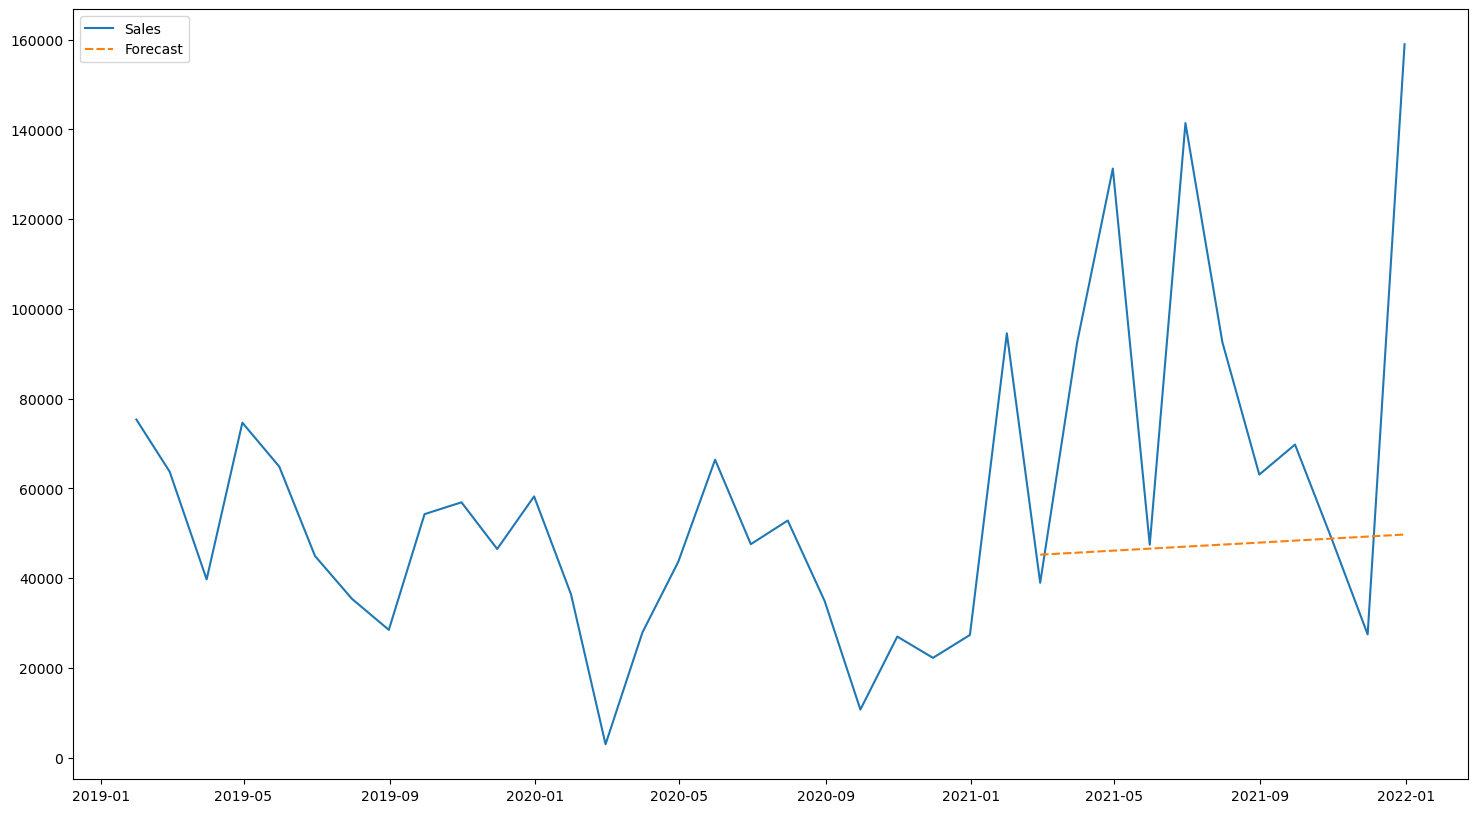

MAPE 41.09489287968483
RMSE 55206.65086223746


In [31]:
DES = Holt(Train).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
PlotValidation(DES,df1)

### Triple Exponential Smoothing (TES)

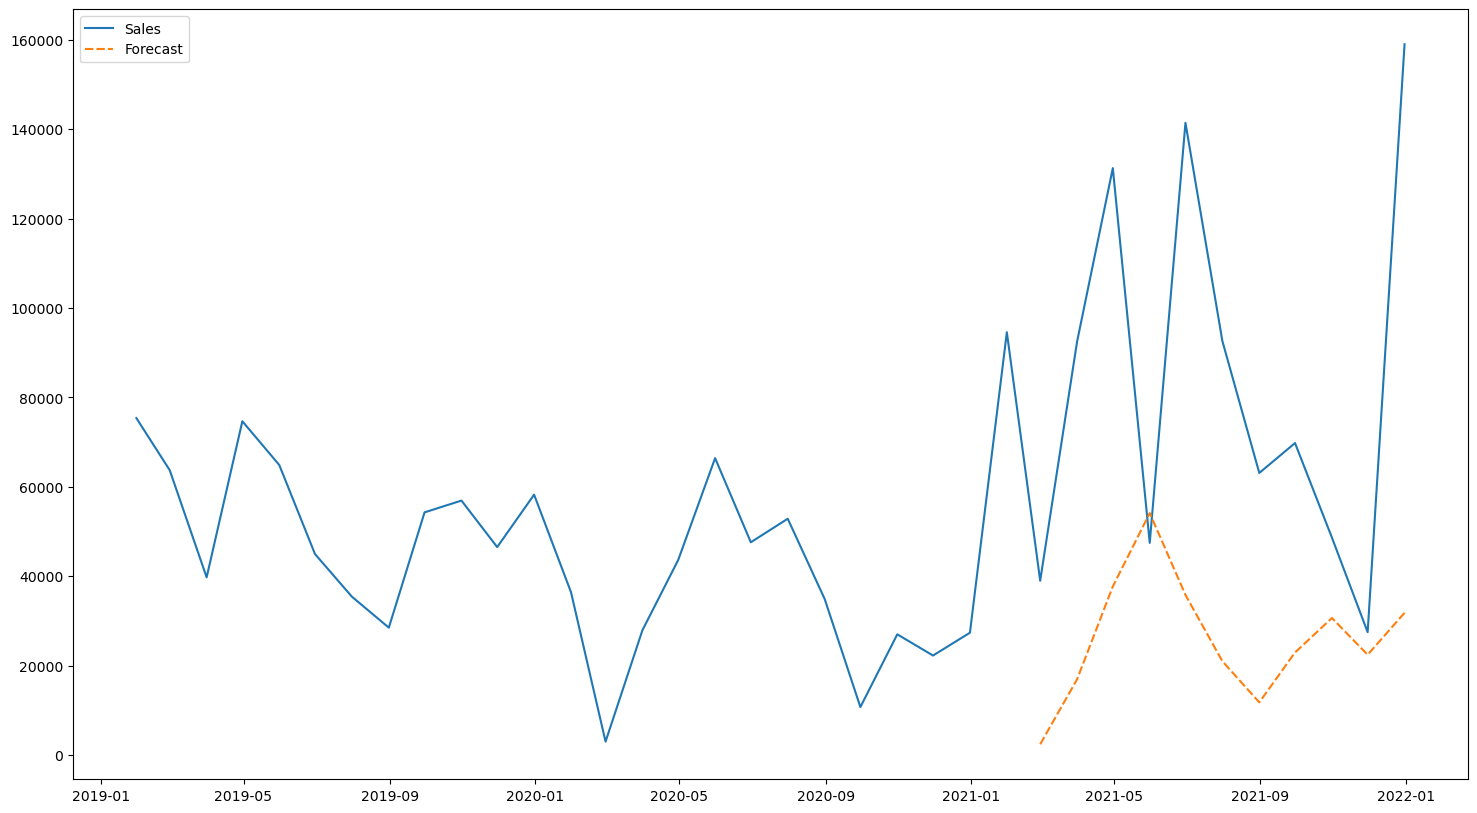

MAPE 63.348607747118635
RMSE 69731.81842675712


In [32]:
TES = ExponentialSmoothing(Train,seasonal='add',trend = 'add').fit()
PlotValidation(TES,df1)

In [30]:
# Finding best parameters for TES

myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)
myGamma = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
gammaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        for gamma in myGamma:
            
            print(alpha, beta, gamma)
                                              
            TES = ExponentialSmoothing(Train, 
                           seasonal='add', # seasonal='add'
                           trend = 'add').fit(smoothing_level = alpha, 
                                      smoothing_slope = beta, 
                                      smoothing_seasonal = gamma)
            
            Forecast = TES.forecast(11).rename('Forecast')
            Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
            Validation_Df = Actual_Forecast_Df[-11:].copy()
            tempMAPE = np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100 # MAPE
            
            
            alphaList.append(alpha)
            betaList.append(beta)
            gammaList.append(gamma)
            mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "gamma": gammaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("df1_TES.csv")

0.0 0.0 0.0
0.0 0.0 0.1
0.0 0.0 0.2
0.0 0.0 0.3
0.0 0.0 0.4
0.0 0.0 0.5
0.0 0.0 0.6
0.0 0.0 0.7
0.0 0.0 0.8
0.0 0.0 0.9
0.0 0.0 1.0
0.0 0.1 0.0
0.0 0.1 0.1
0.0 0.1 0.2
0.0 0.1 0.3
0.0 0.1 0.4
0.0 0.1 0.5
0.0 0.1 0.6
0.0 0.1 0.7
0.0 0.1 0.8
0.0 0.1 0.9
0.0 0.1 1.0
0.0 0.2 0.0
0.0 0.2 0.1
0.0 0.2 0.2
0.0 0.2 0.3
0.0 0.2 0.4
0.0 0.2 0.5
0.0 0.2 0.6
0.0 0.2 0.7
0.0 0.2 0.8
0.0 0.2 0.9
0.0 0.2 1.0
0.0 0.3 0.0
0.0 0.3 0.1
0.0 0.3 0.2
0.0 0.3 0.3
0.0 0.3 0.4
0.0 0.3 0.5
0.0 0.3 0.6
0.0 0.3 0.7
0.0 0.3 0.8
0.0 0.3 0.9
0.0 0.3 1.0
0.0 0.4 0.0
0.0 0.4 0.1
0.0 0.4 0.2
0.0 0.4 0.3
0.0 0.4 0.4
0.0 0.4 0.5
0.0 0.4 0.6
0.0 0.4 0.7
0.0 0.4 0.8
0.0 0.4 0.9
0.0 0.4 1.0
0.0 0.5 0.0
0.0 0.5 0.1
0.0 0.5 0.2
0.0 0.5 0.3
0.0 0.5 0.4
0.0 0.5 0.5
0.0 0.5 0.6
0.0 0.5 0.7
0.0 0.5 0.8
0.0 0.5 0.9
0.0 0.5 1.0
0.0 0.6 0.0
0.0 0.6 0.1
0.0 0.6 0.2
0.0 0.6 0.3
0.0 0.6 0.4
0.0 0.6 0.5
0.0 0.6 0.6
0.0 0.6 0.7
0.0 0.6 0.8
0.0 0.6 0.9
0.0 0.6 1.0
0.0 0.7 0.0
0.0 0.7 0.1
0.0 0.7 0.2
0.0 0.7 0.3
0.0 0.7 0.4
0.0 0.7 0.5
0.0 

0.5 0.7 0.4
0.5 0.7 0.5
0.5 0.7 0.6
0.5 0.7 0.7
0.5 0.7 0.8
0.5 0.7 0.9
0.5 0.7 1.0
0.5 0.8 0.0
0.5 0.8 0.1
0.5 0.8 0.2
0.5 0.8 0.3
0.5 0.8 0.4
0.5 0.8 0.5
0.5 0.8 0.6
0.5 0.8 0.7
0.5 0.8 0.8
0.5 0.8 0.9
0.5 0.8 1.0
0.5 0.9 0.0
0.5 0.9 0.1
0.5 0.9 0.2
0.5 0.9 0.3
0.5 0.9 0.4
0.5 0.9 0.5
0.5 0.9 0.6
0.5 0.9 0.7
0.5 0.9 0.8
0.5 0.9 0.9
0.5 0.9 1.0
0.5 1.0 0.0
0.5 1.0 0.1
0.5 1.0 0.2
0.5 1.0 0.3
0.5 1.0 0.4
0.5 1.0 0.5
0.5 1.0 0.6
0.5 1.0 0.7
0.5 1.0 0.8
0.5 1.0 0.9
0.5 1.0 1.0
0.6 0.0 0.0
0.6 0.0 0.1
0.6 0.0 0.2
0.6 0.0 0.3
0.6 0.0 0.4
0.6 0.0 0.5
0.6 0.0 0.6
0.6 0.0 0.7
0.6 0.0 0.8
0.6 0.0 0.9
0.6 0.0 1.0
0.6 0.1 0.0
0.6 0.1 0.1
0.6 0.1 0.2
0.6 0.1 0.3
0.6 0.1 0.4
0.6 0.1 0.5
0.6 0.1 0.6
0.6 0.1 0.7
0.6 0.1 0.8
0.6 0.1 0.9
0.6 0.1 1.0
0.6 0.2 0.0
0.6 0.2 0.1
0.6 0.2 0.2
0.6 0.2 0.3
0.6 0.2 0.4
0.6 0.2 0.5
0.6 0.2 0.6
0.6 0.2 0.7
0.6 0.2 0.8
0.6 0.2 0.9
0.6 0.2 1.0
0.6 0.3 0.0
0.6 0.3 0.1
0.6 0.3 0.2
0.6 0.3 0.3
0.6 0.3 0.4
0.6 0.3 0.5
0.6 0.3 0.6
0.6 0.3 0.7
0.6 0.3 0.8
0.6 0.3 0.9
0.6 

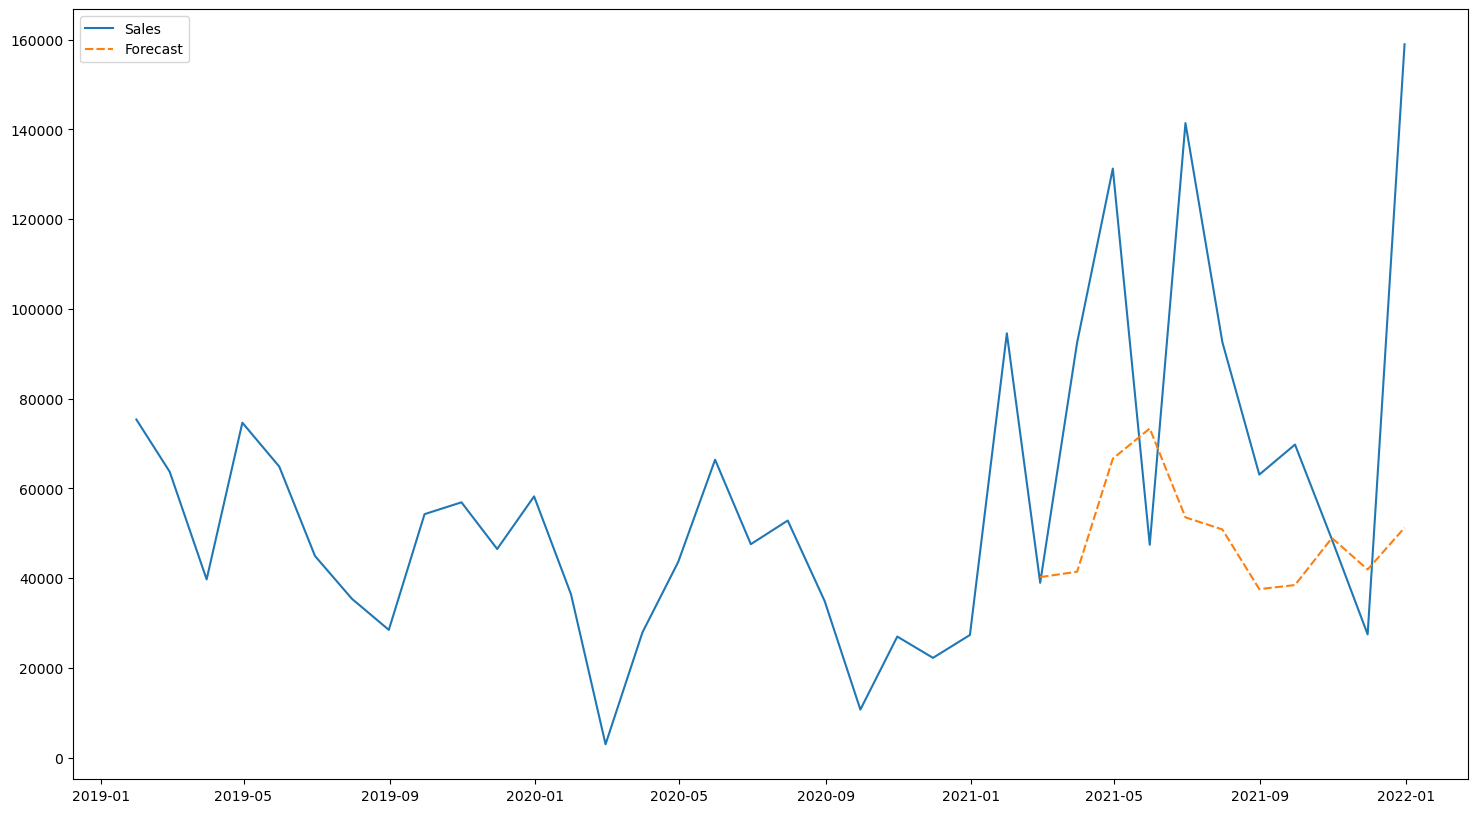

MAPE 43.268153951413176
RMSE 52542.43621938863


In [33]:
TES = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=0.5,smoothing_slope=0,smoothing_seasonal=0.1)
PlotValidation(TES,df1)

MAPE 61.504676320061854


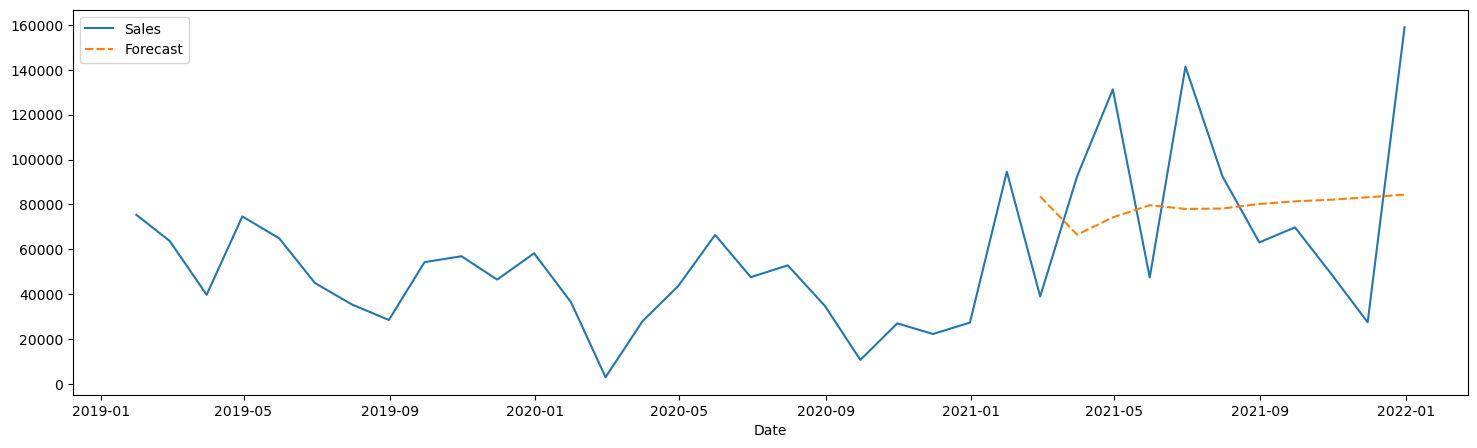

In [38]:
arimaModel = ARIMA((2,1,0),(1,0,0,52)).fit(Train)
Forecast = pd.Series(arimaModel.predict(11)).rename('Forecast')
Forecast.index = Test.index # Needed for the pd.concat to work correctly in the next line
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Validation
Validation_Df = Actual_Forecast_Df[-11:].copy()
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100) # MAPE

MAPE 61.504676320061854


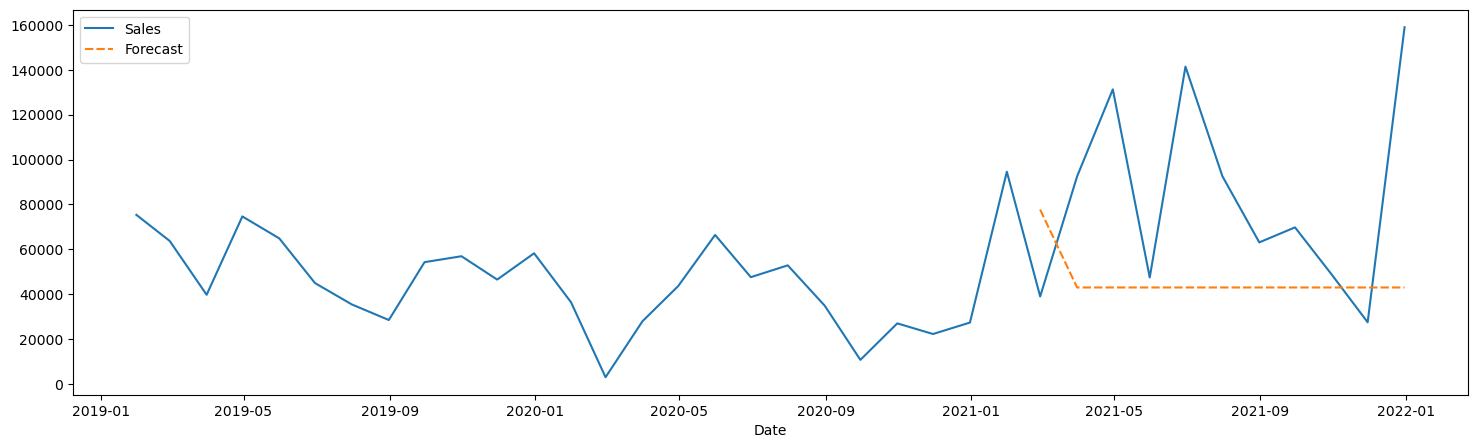

In [39]:
arimaModel2 = auto_arima(Train)
Validation_Df = Actual_Forecast_Df[-11:].copy()
Forecast = pd.Series(arimaModel2.predict(11)).rename('Forecast')
Forecast.index = Test.index
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100) # MAPE

## Stationarity check

In [174]:
def test_stationarity(data):
    
    # Determining rolling statistics
    movingAvg = data.rolling(window=12).mean()
    movingStd = data.rolling(window=12).std()
    
    # Plotting
    orig = plt.plot(data,color='blue',label='original')
    mean = plt.plot(movingAvg,color='red',label='Rolling Mean')
    std = plt.plot(movingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard deviation")
    plt.show()
    
    # ADF Test
    dftest = adfuller(data,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#lags used','Number of observation used'])
    print(dfoutput)
    if dfoutput[1] > 0.05:
        print('\nData is nonstationary')
    else:
        print('\nData is stationary')

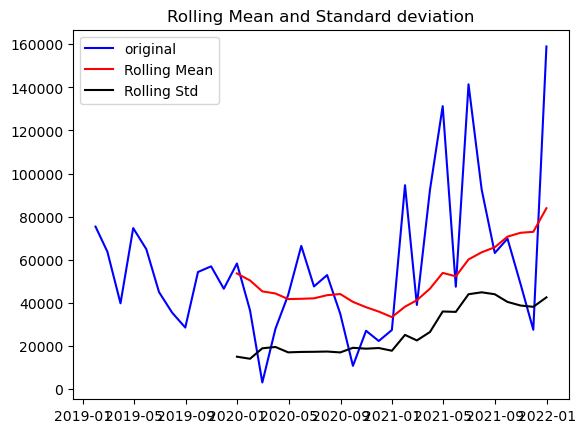

Test Statistics               -0.624700
p-value                        0.865303
#lags used                     5.000000
Number of observation used    30.000000
dtype: float64

Data is nonstationary


In [175]:
test_stationarity(df1)

### Log Transformation

In [176]:
df_log = np.log(df1)

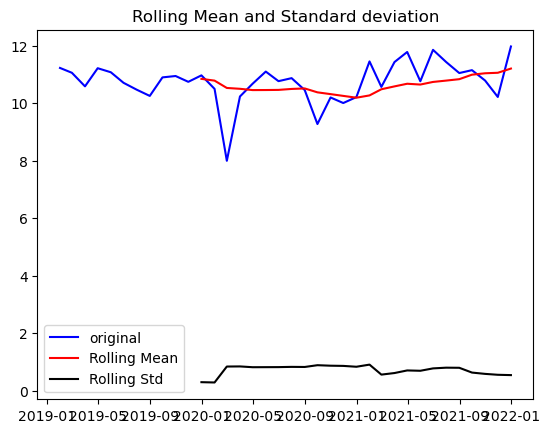

Test Statistics               -4.094836
p-value                        0.000988
#lags used                     0.000000
Number of observation used    35.000000
dtype: float64

Data is stationary


In [177]:
test_stationarity(df_log)

### Split in test and train in exactly 70 and 30% 

In [178]:
Train,Test = split(df_log)

In [179]:
Train.shape

(25,)

In [180]:
Test.shape

(11,)

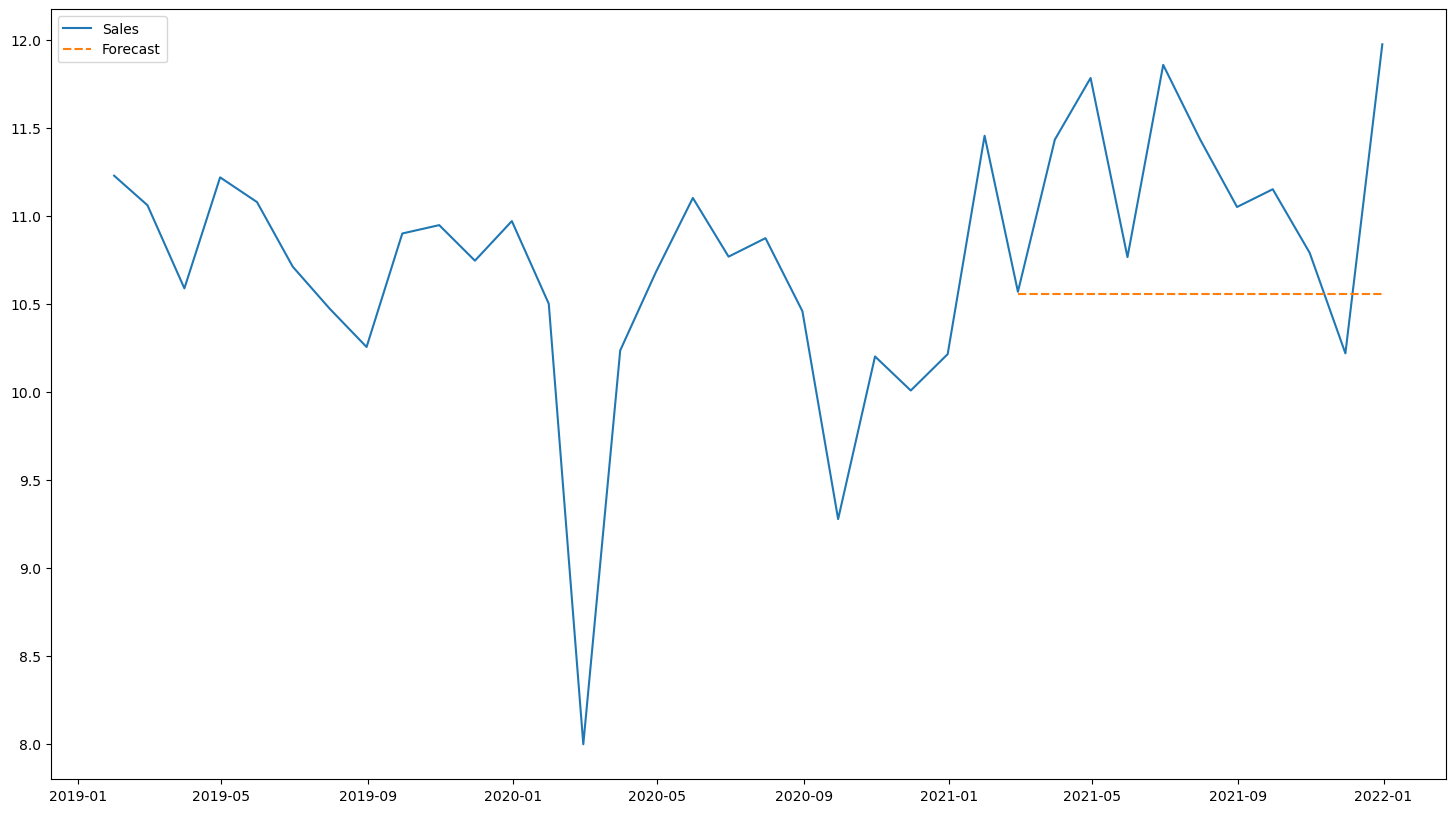

MAPE 5.9794865826153325
RMSE 0.8278243393204772


In [181]:
SES = SimpleExpSmoothing(Train).fit()
PlotValidation(SES,df_log)

### Double Exponential Smoothing (DES)

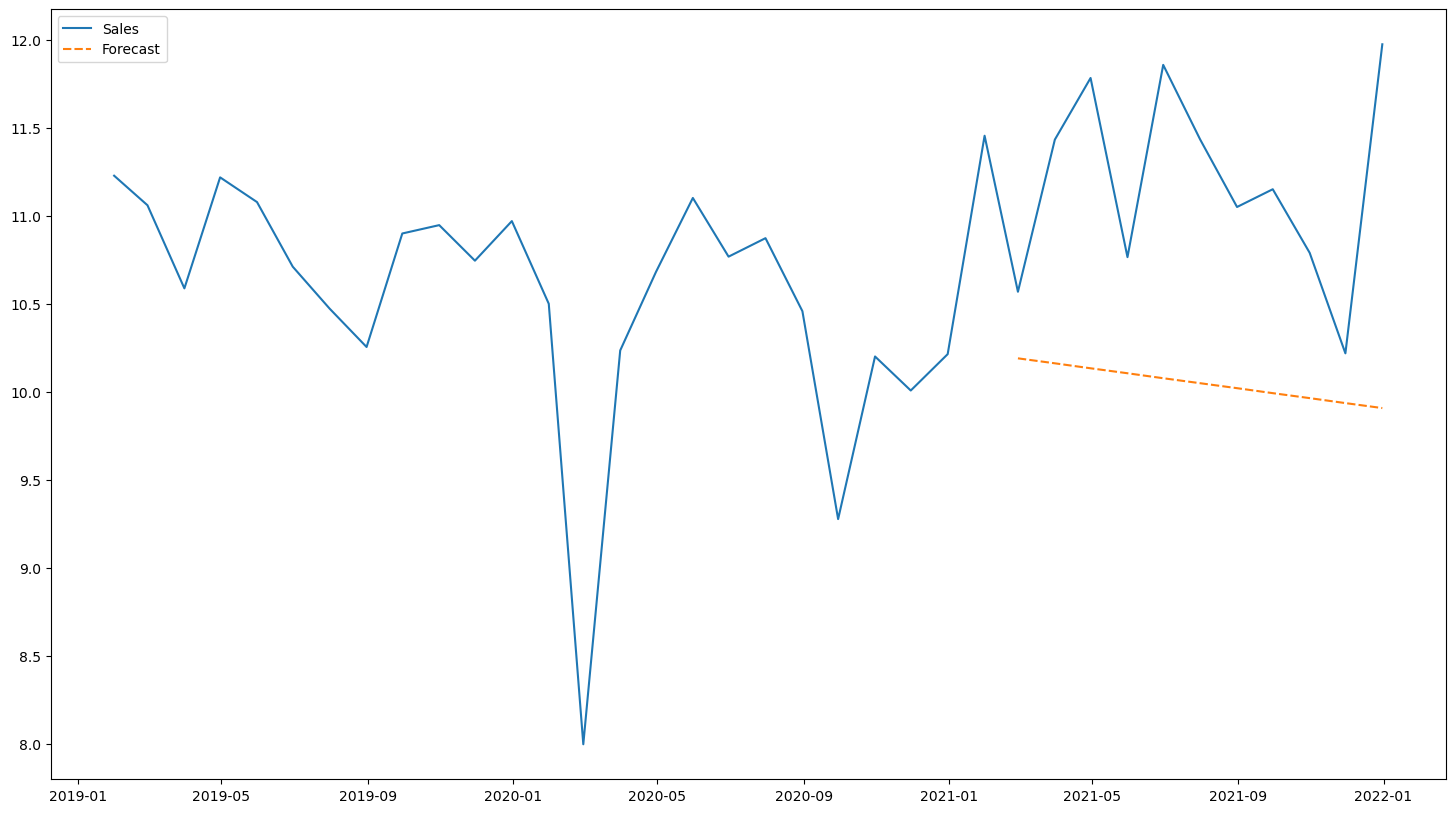

MAPE 9.93617607436977
RMSE 1.2588769338243937


In [42]:
DES = Holt(Train).fit()
PlotValidation(DES,df_log)

In [43]:
# Finding best parameters
myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        print(alpha, beta)
        DES = Holt(Train).fit(smoothing_level = alpha,smoothing_slope = beta)
        Forecast = DES.forecast(11).rename('Forecast')
        Actual_Forecast_Df = pd.concat([df_log, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-11:].copy()
        tempMAPE = np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100 # MAPE
            
            
        alphaList.append(alpha)
        betaList.append(beta)
        mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("dflog_DES.csv")

0.0 0.0
0.0 0.1
0.0 0.2
0.0 0.3
0.0 0.4
0.0 0.5
0.0 0.6
0.0 0.7
0.0 0.8
0.0 0.9
0.0 1.0
0.1 0.0
0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.1 1.0
0.2 0.0
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.2 1.0
0.3 0.0
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9
0.3 1.0
0.4 0.0
0.4 0.1
0.4 0.2
0.4 0.3
0.4 0.4
0.4 0.5
0.4 0.6
0.4 0.7
0.4 0.8
0.4 0.9
0.4 1.0
0.5 0.0
0.5 0.1
0.5 0.2
0.5 0.3
0.5 0.4
0.5 0.5
0.5 0.6
0.5 0.7
0.5 0.8
0.5 0.9
0.5 1.0
0.6 0.0
0.6 0.1
0.6 0.2
0.6 0.3
0.6 0.4
0.6 0.5
0.6 0.6
0.6 0.7
0.6 0.8
0.6 0.9
0.6 1.0
0.7 0.0
0.7 0.1
0.7 0.2
0.7 0.3
0.7 0.4
0.7 0.5
0.7 0.6
0.7 0.7
0.7 0.8
0.7 0.9
0.7 1.0
0.8 0.0
0.8 0.1
0.8 0.2
0.8 0.3
0.8 0.4
0.8 0.5
0.8 0.6
0.8 0.7
0.8 0.8
0.8 0.9
0.8 1.0
0.9 0.0
0.9 0.1
0.9 0.2
0.9 0.3
0.9 0.4
0.9 0.5
0.9 0.6
0.9 0.7
0.9 0.8
0.9 0.9
0.9 1.0
1.0 0.0
1.0 0.1
1.0 0.2
1.0 0.3
1.0 0.4
1.0 0.5
1.0 0.6
1.0 0.7
1.0 0.8
1.0 0.9
1.0 1.0


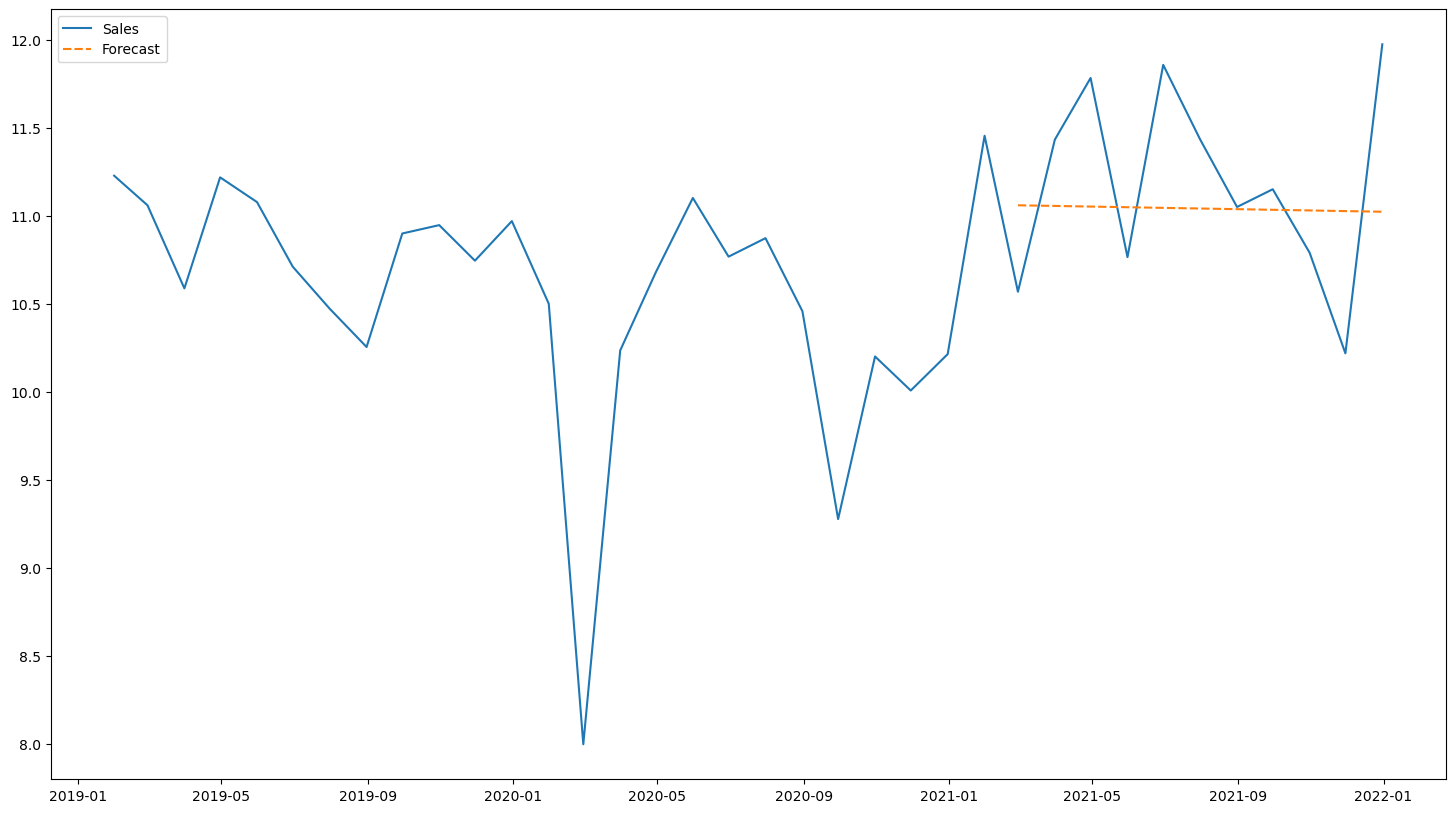

MAPE 4.20859507791452
RMSE 0.559293161165495


In [44]:
DES = Holt(Train).fit(smoothing_level = 0.7,smoothing_slope = 0)
PlotValidation(DES,df_log)

### Triple Exponential Smoothing (TES)

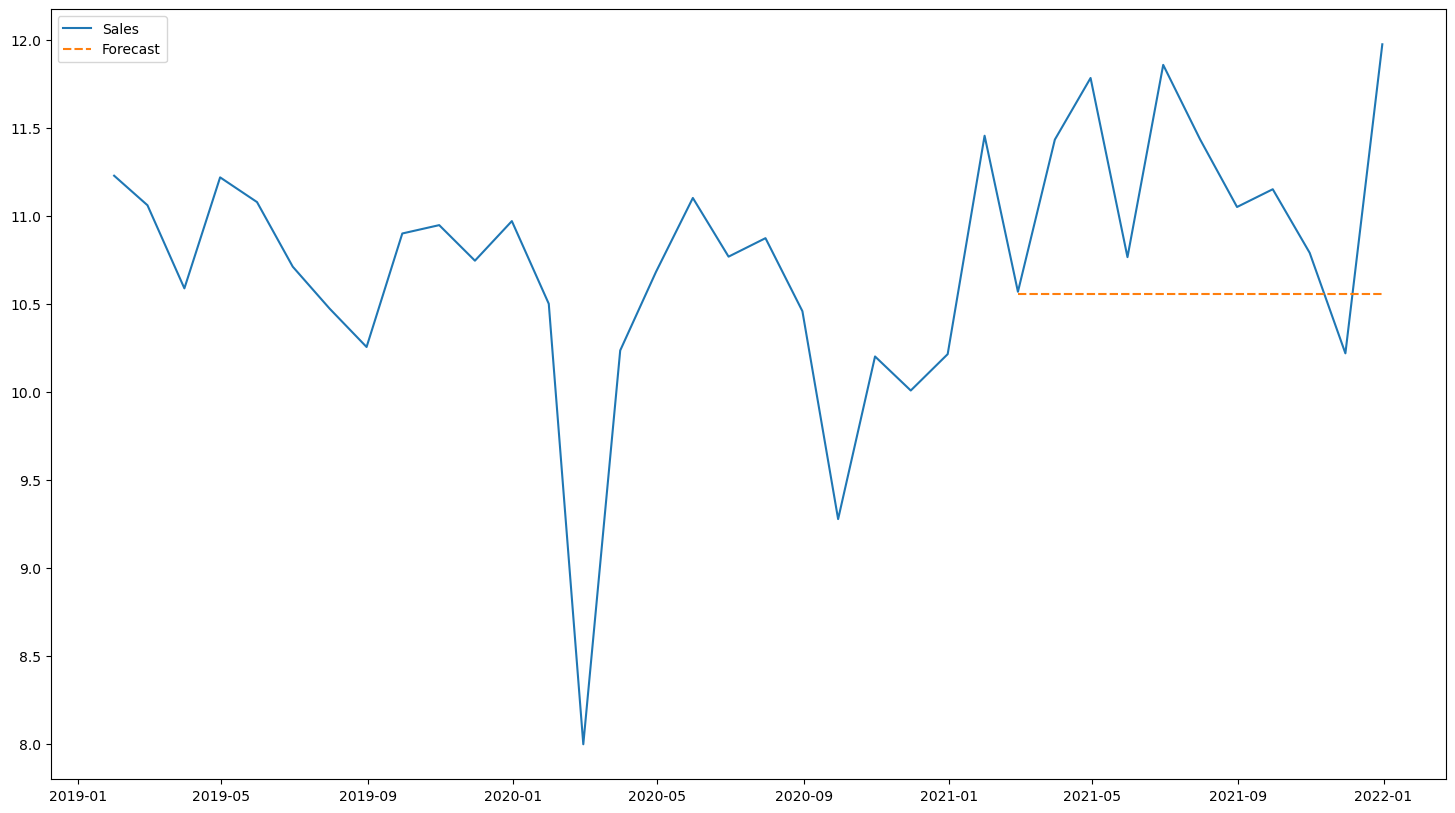

MAPE 5.979497831601307
RMSE 0.8278239691632626


In [45]:
TES = ExponentialSmoothing(Train).fit()
PlotValidation(TES,df_log)

In [46]:
myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)
myGamma = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
gammaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        for gamma in myGamma:
            
            print(alpha, beta, gamma)
                                              
            TES = ExponentialSmoothing(Train, 
                           seasonal='add', # seasonal='add'
                           trend = 'add').fit(smoothing_level = alpha, 
                                      smoothing_slope = beta, 
                                      smoothing_seasonal = gamma)
            
            Forecast = TES.forecast(11).rename('Forecast')
            Actual_Forecast_Df = pd.concat([df_log, Forecast], axis = 1)
            Validation_Df = Actual_Forecast_Df[-11:].copy()
            tempMAPE = np.mean(abs(Validation_Df['Sales'] - Validation_Df['Forecast'])/Validation_Df['Sales'])*100 # MAPE
            
            
            alphaList.append(alpha)
            betaList.append(beta)
            gammaList.append(gamma)
            mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "gamma": gammaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("dflog_TES.csv")

0.0 0.0 0.0
0.0 0.0 0.1
0.0 0.0 0.2
0.0 0.0 0.3
0.0 0.0 0.4
0.0 0.0 0.5
0.0 0.0 0.6
0.0 0.0 0.7
0.0 0.0 0.8
0.0 0.0 0.9
0.0 0.0 1.0
0.0 0.1 0.0
0.0 0.1 0.1
0.0 0.1 0.2
0.0 0.1 0.3
0.0 0.1 0.4
0.0 0.1 0.5
0.0 0.1 0.6
0.0 0.1 0.7
0.0 0.1 0.8
0.0 0.1 0.9
0.0 0.1 1.0
0.0 0.2 0.0
0.0 0.2 0.1
0.0 0.2 0.2
0.0 0.2 0.3
0.0 0.2 0.4
0.0 0.2 0.5
0.0 0.2 0.6
0.0 0.2 0.7
0.0 0.2 0.8
0.0 0.2 0.9
0.0 0.2 1.0
0.0 0.3 0.0
0.0 0.3 0.1
0.0 0.3 0.2
0.0 0.3 0.3
0.0 0.3 0.4
0.0 0.3 0.5
0.0 0.3 0.6
0.0 0.3 0.7
0.0 0.3 0.8
0.0 0.3 0.9
0.0 0.3 1.0
0.0 0.4 0.0
0.0 0.4 0.1
0.0 0.4 0.2
0.0 0.4 0.3
0.0 0.4 0.4
0.0 0.4 0.5
0.0 0.4 0.6
0.0 0.4 0.7
0.0 0.4 0.8
0.0 0.4 0.9
0.0 0.4 1.0
0.0 0.5 0.0
0.0 0.5 0.1
0.0 0.5 0.2
0.0 0.5 0.3
0.0 0.5 0.4
0.0 0.5 0.5
0.0 0.5 0.6
0.0 0.5 0.7
0.0 0.5 0.8
0.0 0.5 0.9
0.0 0.5 1.0
0.0 0.6 0.0
0.0 0.6 0.1
0.0 0.6 0.2
0.0 0.6 0.3
0.0 0.6 0.4
0.0 0.6 0.5
0.0 0.6 0.6
0.0 0.6 0.7
0.0 0.6 0.8
0.0 0.6 0.9
0.0 0.6 1.0
0.0 0.7 0.0
0.0 0.7 0.1
0.0 0.7 0.2
0.0 0.7 0.3
0.0 0.7 0.4
0.0 0.7 0.5
0.0 

0.5 0.7 0.2
0.5 0.7 0.3
0.5 0.7 0.4
0.5 0.7 0.5
0.5 0.7 0.6
0.5 0.7 0.7
0.5 0.7 0.8
0.5 0.7 0.9
0.5 0.7 1.0
0.5 0.8 0.0
0.5 0.8 0.1
0.5 0.8 0.2
0.5 0.8 0.3
0.5 0.8 0.4
0.5 0.8 0.5
0.5 0.8 0.6
0.5 0.8 0.7
0.5 0.8 0.8
0.5 0.8 0.9
0.5 0.8 1.0
0.5 0.9 0.0
0.5 0.9 0.1
0.5 0.9 0.2
0.5 0.9 0.3
0.5 0.9 0.4
0.5 0.9 0.5
0.5 0.9 0.6
0.5 0.9 0.7
0.5 0.9 0.8
0.5 0.9 0.9
0.5 0.9 1.0
0.5 1.0 0.0
0.5 1.0 0.1
0.5 1.0 0.2
0.5 1.0 0.3
0.5 1.0 0.4
0.5 1.0 0.5
0.5 1.0 0.6
0.5 1.0 0.7
0.5 1.0 0.8
0.5 1.0 0.9
0.5 1.0 1.0
0.6 0.0 0.0
0.6 0.0 0.1
0.6 0.0 0.2
0.6 0.0 0.3
0.6 0.0 0.4
0.6 0.0 0.5
0.6 0.0 0.6
0.6 0.0 0.7
0.6 0.0 0.8
0.6 0.0 0.9
0.6 0.0 1.0
0.6 0.1 0.0
0.6 0.1 0.1
0.6 0.1 0.2
0.6 0.1 0.3
0.6 0.1 0.4
0.6 0.1 0.5
0.6 0.1 0.6
0.6 0.1 0.7
0.6 0.1 0.8
0.6 0.1 0.9
0.6 0.1 1.0
0.6 0.2 0.0
0.6 0.2 0.1
0.6 0.2 0.2
0.6 0.2 0.3
0.6 0.2 0.4
0.6 0.2 0.5
0.6 0.2 0.6
0.6 0.2 0.7
0.6 0.2 0.8
0.6 0.2 0.9
0.6 0.2 1.0
0.6 0.3 0.0
0.6 0.3 0.1
0.6 0.3 0.2
0.6 0.3 0.3
0.6 0.3 0.4
0.6 0.3 0.5
0.6 0.3 0.6
0.6 0.3 0.7
0.6 

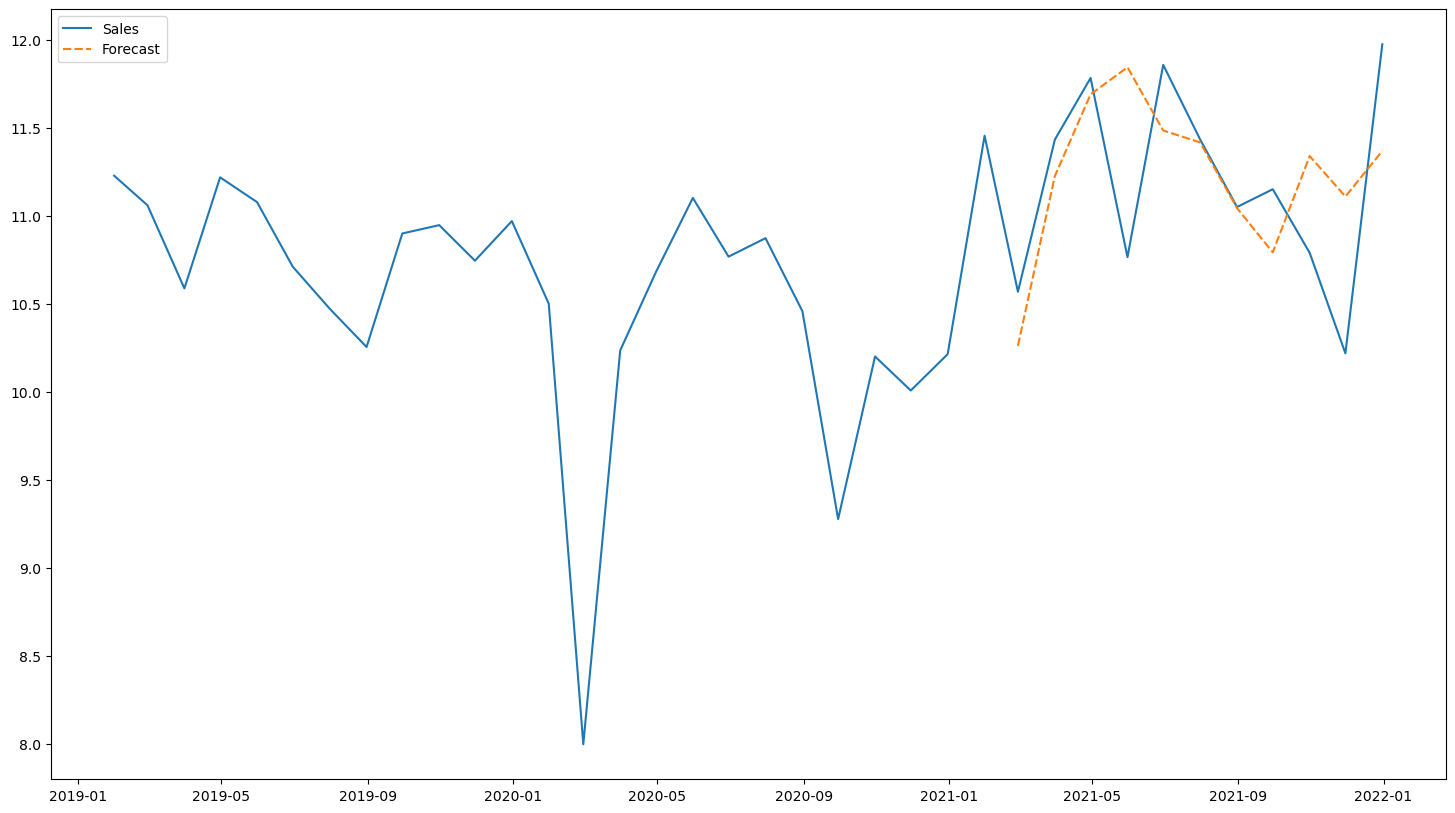

MAPE 3.7232488607288303
RMSE 0.5257207217745007


In [47]:
TES = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=1,smoothing_slope=0,smoothing_seasonal=0.1)
PlotValidation(TES,df_log)

### Forecasting with finalized model

In [182]:
Final_TES2 = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=1,smoothing_slope=0,smoothing_seasonal=0.1)

In [183]:
## Forecasting
Forecast = pd.Series(Final_TES2.predict(0)).rename('Forecast')
Forecast

Date
2019-01-31    11.094267
2019-02-28     9.994528
2019-03-31    11.979470
2019-04-30    11.076979
2019-05-31    11.365698
2019-06-30    10.726066
2019-07-31    10.640986
2019-08-31    10.093883
2019-09-30    10.031320
2019-10-31    11.427269
2019-11-30    10.724628
2019-12-31    11.016133
2020-01-31    11.350596
2020-02-29     9.360163
2020-03-31     8.671584
2020-04-30    10.877596
2020-05-31    10.785057
2020-06-30    10.776799
2020-07-31    10.682631
2020-08-31    10.527327
2020-09-30    10.305511
2020-10-31     9.669847
2020-11-30    10.028525
2020-12-31    10.271898
2021-01-31    10.514356
Freq: M, Name: Forecast, dtype: float64

In [187]:
# Set the correct dates as index of the forecast obtained in the previous line
start = "2021-02-28"
end = "2023-2-28"
futureDateRange = pd.date_range(start, end, freq='M')

In [188]:
Forecast.index = futureDateRange 

In [189]:
Actual_Forecast_Df = pd.concat([df_log,Forecast], axis = 1) # Column wise binding

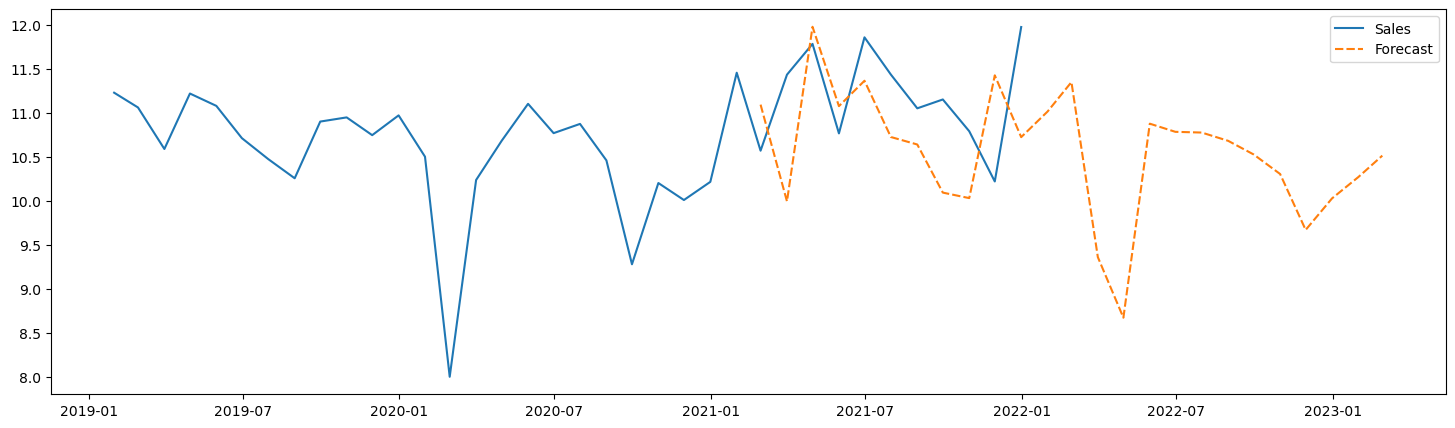

In [190]:
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
plt.show()

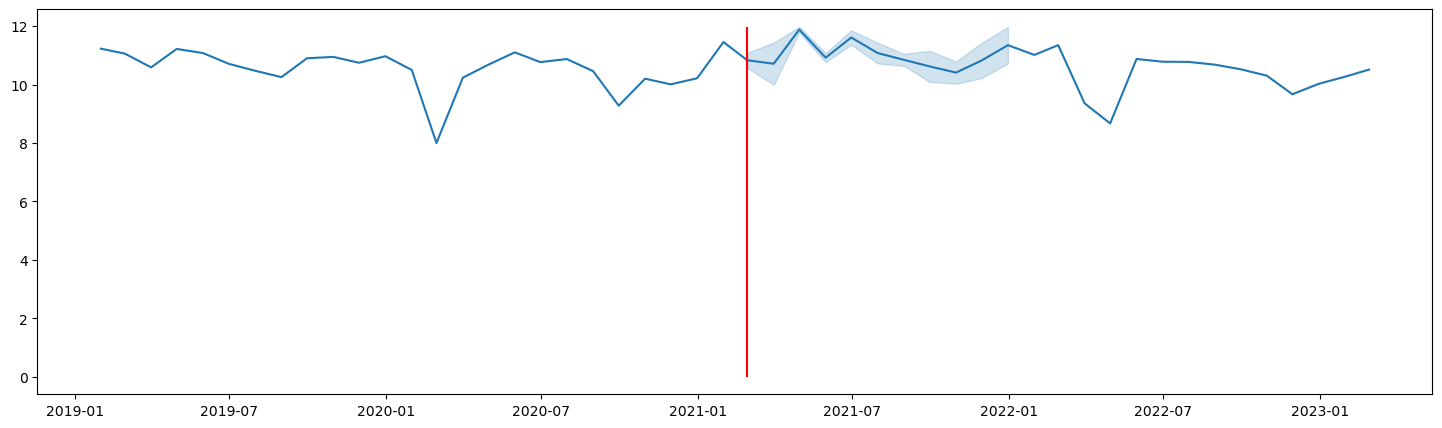

In [191]:
Actual_Forecast_Series = pd.concat([df_log, Forecast], axis = 0) # Row wise binding
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Series)
vlines(x = Actual_Forecast_Series.index[36],ymin=0,ymax = max(Actual_Forecast_Series), colors = "red")
plt.show()